In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Tuple
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
import pandas as pd

In [2]:

class DataPreprocessor:
    def __init__(self, location_mask, measurement_mask, dataset, downsample_factor=30):
        """
        Args:
            location_mask (np.ndarray): (H, W, 2) coordinates.
            measurement_mask (np.ndarray): (H, W) or (H, W, 1), indicating measurement locations.
            dataset (np.ndarray): (N, H, W), N = number of samples.
            downsample_factor (int): Number of samples to average together.
        """
        self.location_mask = location_mask
        self.measurement_mask = measurement_mask
        self.dataset = dataset
        self.downsample_factor = downsample_factor

    def downsample(self):
        """Downsample by averaging over 'downsample_factor' samples."""
        n_samples = self.dataset.shape[0]
        n_groups = n_samples // self.downsample_factor  # ✅ define this
        ds_data = []

        for i in range(n_groups):
            start = i * self.downsample_factor
            end = start + self.downsample_factor
            avg_sample = np.mean(self.dataset[start:end], axis=0)
            ds_data.append(avg_sample)

        return np.stack(ds_data)
    
    def get_prepared_data(self):
        X = self.downsample()
        return X


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple

class ConditionalVAE(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 loc_channels: int = 2,
                 mask_channels: int = 1,
                 latent_dim: int = 16,
                 hidden_dims: List[int] = [32, 64, 128, 256, 512],
                 img_size: int = 40):
        super().__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.in_channels = in_channels
        self.loc_channels = loc_channels
        self.mask_channels = mask_channels

        # ---------------- Encoder ----------------
        enc_in_channels = in_channels + loc_channels + mask_channels
        self.hidden_dims_enc = hidden_dims
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(enc_in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            enc_in_channels = h_dim
        self.encoder = nn.Sequential(*modules)

        # Compute encoder output sizes dynamically
        encoder_sizes = self.compute_encoder_sizes(img_size, hidden_dims)
        self.final_spatial = encoder_sizes[-1]
        flat_size = hidden_dims[-1] * self.final_spatial**2

        # Latent space
        self.fc_mu = nn.Linear(flat_size, latent_dim)
        self.fc_var = nn.Linear(flat_size, latent_dim)

        # ---------------- Decoder ----------------
        self.decoder_input = nn.Linear(
            latent_dim + (loc_channels + mask_channels) * img_size * img_size,
            flat_size
        )

        self.hidden_dims_dec = hidden_dims[::-1]

        dec_modules = []
        for i in range(len(self.hidden_dims_dec) - 1):
            dec_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        self.hidden_dims_dec[i],
                        self.hidden_dims_dec[i+1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=0  # always 0, we will pad later
                    ),
                    nn.BatchNorm2d(self.hidden_dims_dec[i+1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*dec_modules)

        self.final_mu = nn.Conv2d(self.hidden_dims_dec[-1], out_channels=in_channels, kernel_size=3, padding=1)
        self.final_logvar = nn.Conv2d(self.hidden_dims_dec[-1], out_channels=in_channels, kernel_size=3, padding=1)

    # ---------------- Static methods ----------------
    @staticmethod
    def compute_encoder_sizes(img_size, hidden_dims, kernel_size=3, stride=2, padding=1):
        sizes = []
        size = img_size
        for _ in hidden_dims:
            size = (size + 2*padding - kernel_size) // stride + 1
            sizes.append(size)
        return sizes

    # ---------------- Forward methods ----------------
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: torch.Tensor, loc_mask: torch.Tensor, meas_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Combine conditioning info
        cond = torch.cat([loc_mask, meas_mask], dim=1)
        cond_flat = cond.view(cond.size(0), -1)
        dec_input = torch.cat([z, cond_flat], dim=1)

        result = self.decoder_input(dec_input)
        result = result.view(-1, self.hidden_dims_dec[0], self.final_spatial, self.final_spatial)
        result = self.decoder(result)

        # Zero-pad to ensure output is img_size x img_size
        _, _, h, w = result.shape
        pad_h = self.img_size - h
        pad_w = self.img_size - w
        if pad_h > 0 or pad_w > 0:
            # pad = (left, right, top, bottom)
            result = F.pad(result, (0, pad_w, 0, pad_h))

        mu_pred = self.final_mu(result)
        logvar_pred = torch.clamp(self.final_logvar(result), -10, 10)
        return mu_pred, logvar_pred

    def forward(self, x: torch.Tensor, loc_mask: torch.Tensor, meas_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Tile location mask if needed
        if loc_mask.dim() == 3:
            loc_mask = loc_mask.unsqueeze(0).repeat(x.size(0), 1, 1, 1)

        enc_in = torch.cat([x, loc_mask, meas_mask], dim=1)
        mu, log_var = self.encode(enc_in)
        z = self.reparameterize(mu, log_var)
        mu_pred, logvar_pred = self.decode(z, loc_mask, meas_mask)
        return mu_pred, logvar_pred, mu, log_var

    # ---------------- Loss function ----------------
    def loss_function(self, x: torch.Tensor, mu_pred: torch.Tensor, logvar_pred: torch.Tensor,
                      mu: torch.Tensor, log_var: torch.Tensor, kld_weight: float = 1e-3) -> dict:
        const = torch.log(torch.tensor(2.0 * torch.pi, device=x.device))
        recon_var = torch.exp(logvar_pred)
        nll_element = 0.5 * ((x - mu_pred)**2 / recon_var + logvar_pred + const)
        nll_loss = torch.mean(torch.sum(nll_element, dim=[1,2,3]))

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        total_loss = nll_loss + kld_weight * kld_loss
        return {"loss": total_loss, "NLL": nll_loss, "KLD": kld_loss}


In [4]:
""" N, H, W = 1500, 40, 40
location_mask = np.random.rand(H, W, 2)
measurement_mask = np.random.randint(0, 2, (H, W))
dataset = np.random.rand(N, H, W)

prep = DataPreprocessor(location_mask, measurement_mask, dataset, downsample_factor=30)
X = prep.get_prepared_data()  # shape (N//30, H, W)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)         # (batch, 1, H, W)
loc_mask = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)
meas_mask = torch.tensor(measurement_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

# Repeat masks for all samples in batch
loc_mask = loc_mask.repeat(X.size(0), 1, 1, 1)
meas_mask = meas_mask.repeat(X.size(0), 1, 1, 1)

# Create Dataset + DataLoader
dataset = TensorDataset(X, loc_mask, meas_mask)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# ===============================================================
# 2️⃣ Initialize model + optimizer
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims=[32, 64, 128, 256, 512]

model = ConditionalVAE(
    in_channels=1,
    loc_channels=2,
    mask_channels=1,
    latent_dim=16,
    img_size=H,
    hidden_dims=hidden_dims,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 50
kld_weight = 1e-3  # you can anneal this if needed

# ===============================================================
# 3️⃣ Training loop
# ===============================================================
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0

    for x_batch, loc_batch, mask_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_batch = x_batch.to(device)
        loc_batch = loc_batch.to(device)
        mask_batch = mask_batch.to(device)

        optimizer.zero_grad()
        mu_pred, logvar_pred, mu, log_var = model(x_batch,loc_batch, mask_batch)
        losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
        loss = losses["loss"]

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for x_batch, loc_batch, mask_batch in val_loader:
            x_batch = x_batch.to(device)
            loc_batch = loc_batch.to(device)
            mask_batch = mask_batch.to(device)
            mu_pred, logvar_pred, mu, log_var = model(x_batch, loc_batch, mask_batch)
            losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
            val_loss += losses["loss"].item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ===============================================================
# 4️⃣ Save model
# ===============================================================
torch.save(model.state_dict(), "sivae_sinr.pt")
print("✅ Training complete! Model saved.") """

' N, H, W = 1500, 40, 40\nlocation_mask = np.random.rand(H, W, 2)\nmeasurement_mask = np.random.randint(0, 2, (H, W))\ndataset = np.random.rand(N, H, W)\n\nprep = DataPreprocessor(location_mask, measurement_mask, dataset, downsample_factor=30)\nX = prep.get_prepared_data()  # shape (N//30, H, W)\n\n# Convert to torch tensors\nX = torch.tensor(X, dtype=torch.float32).unsqueeze(1)         # (batch, 1, H, W)\nloc_mask = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)\nmeas_mask = torch.tensor(measurement_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)\n\n# Repeat masks for all samples in batch\nloc_mask = loc_mask.repeat(X.size(0), 1, 1, 1)\nmeas_mask = meas_mask.repeat(X.size(0), 1, 1, 1)\n\n# Create Dataset + DataLoader\ndataset = TensorDataset(X, loc_mask, meas_mask)\ntrain_size = int(0.8 * len(dataset))\nval_size = len(dataset) - train_size\ntrain_data, val_data = random_split(dataset, [train_size, val_size])\n\ntrain

In [14]:
import pandas as pd
import numpy as np
import torch

# --- Define constants ---
H, W = 40, 40

# --- Load SINR data FIRST to determine N ---
# --- EDIT: This file is now assumed to have 30 SENSOR rows ---
print("Loading combined_sinr.csv to determine N...")
df_dataset = pd.read_csv('combined_sinr.csv') 

# Get all SINR column names
sinr_cols = [col for col in df_dataset.columns if col.startswith('SINR_')]
N = len(sinr_cols)
print(f"Determined N = {N} samples from SINR columns.")
print(f"Found {df_dataset.shape[0]} sensor rows in SINR file.")


# --- 1. Load LOCATION MASK (Your grid_coordinates.csv) ---
df_grid = pd.read_csv('original_1600_grid_points.csv') # This is the 1600-row file

# Get the Y and X values (Y first for (row, col))
y_values = df_grid['y'].to_numpy()
x_values = df_grid['x'].to_numpy()

# Stack them (1600, 2) and reshape (40, 40, 2)
location_values = np.stack([y_values, x_values], axis=-1)
location_mask = location_values.reshape(H, W, 2) 

print(f"Loaded location_mask, shape: {location_mask.shape}") # (40, 40, 2)

# --- NEW: Create (Y, X) pixel indices for all 1600 grid points ---
all_y_pixel_indices = np.arange(H * W) // W  # [0,0,...,0, 1,1,...,1, ...]
all_x_pixel_indices = np.arange(H * W) % W   # [0,1,...,39, 0,1,...,39, ...]

# --- 2. Load SENSOR LIST (Your Mask_points_with_measured_flag.csv) ---
# This file MUST still have all 1600 grid points
df_mask = pd.read_csv('mask.csv')

FLAG_COL = 'mask'   

# --- Create a boolean mask from all 1600 rows ---
boolean_sensor_mask = (df_mask[FLAG_COL] == 1).to_numpy() # Shape (1600,)
num_sensors_from_mask = boolean_sensor_mask.sum()
print(f"Created boolean mask with {num_sensors_from_mask} sensors from mask.csv.")

# --- REPLACEMENT: Get pixel indices for sensors ---
# Use the boolean mask to filter our generated (y, x) pixel indices
y_indices = all_y_pixel_indices[boolean_sensor_mask]
x_indices = all_x_pixel_indices[boolean_sensor_mask]

# Check if we got the right number of sensors
num_train_locs = len(y_indices)
if num_train_locs != num_sensors_from_mask:
    print(f"Warning: Mismatch in sensor count. {num_train_locs} vs {num_sensors_from_mask}")

# 3. Create the (Y, X) tensors for the training loop
train_coords_y = torch.tensor(y_indices, dtype=torch.long)
train_coords_x = torch.tensor(x_indices, dtype=torch.long)

print(f"Extracted {num_train_locs} sensor locations for training.")

# --- EDIT: Add a check to ensure SINR file matches mask file ---
if df_dataset.shape[0] != num_train_locs:
    print(f"\n--- CRITICAL WARNING ---")
    print(f"SINR file has {df_dataset.shape[0]} rows.")
    print(f"Mask file has {num_train_locs} sensors.")
    print(f"These numbers MUST match for the code to work correctly.")
    print(f"------------------------\n")
# ----------------------------------------------------------------

# 4. Select specific validation points using provided indices
print("\n--- Creating Validation Set from Specific Indices ---")

my_val_indices = [3, 6, 25, 12, 13, 17, 19, 21, 10, 2]

val_coords_y = train_coords_y[my_val_indices]
val_coords_x = train_coords_x[my_val_indices]

print(f"Created specific validation set with {len(val_coords_y)} locations from indices.")
print(f"Validation Y indices: {val_coords_y}")
print(f"Validation X indices: {val_coords_x}")
print("----------------------------------------------------------\n")

# --- Data is already loaded, just filter it ---
# print("Loading measured_points_with_sinr.csv...") # <-- Already done
# df_dataset = pd.read_csv('sinr_output.csv') # <-- Already done

# --- ------------------------------------------------- ---
# --- EDIT: This section is changed. We no longer filter. ---
# --- We assume df_dataset (from combined_sinr.csv)     ---
# --- already contains *only* the 30 sensor rows.       ---
# --- ------------------------------------------------- ---

# Get the SINR data, shape (30, N)
# We use df_dataset directly, NOT a filtered version.
sinr_data = df_dataset[sinr_cols].to_numpy()

# Transpose to (N_samples, N_sensors), shape (N, 30)
sinr_data_transposed = sinr_data.T
print(f"Loaded SINR data, shape {sinr_data_transposed.shape}") # Should be (N, 30)

# --- 4. Build the (N, H, W) dataset ---
# Create an empty (N, 40, 40) array
dataset_images = np.zeros((N, H, W), dtype=np.float32)

# --- This loop remains correct ---
# It maps the 30 values from 'sinr_data_transposed'
# to the 30 (y, x) coordinates from 'y_indices' and 'x_indices'
for i in range(N):
    # Get the 30 sensor values for this sample. Shape is (30,)
    sample_values = sinr_data_transposed[i]
    
    # Place each sensor value at its (y, x) pixel location
    # Destination shape (30,) = Source shape (30,)
    dataset_images[i, y_indices, x_indices] = sample_values

print(f"Built (N, H, W) dataset, shape: {dataset_images.shape}")

# ---------------------------
# 5. PREPROCESS THE DATA
# ---------------------------

print("\n--- NORMALIZING SENSOR VALUES ONLY (zeros stay zero) ---")

dataset_images = torch.tensor(dataset_images, dtype=torch.float32)   # (N, 40, 40)

# Mask of real sensors (30 per map)
sensor_mask = dataset_images != 0   # shape (N, 40, 40)

# Extract all non-zero sensor values across dataset
sensor_vals = dataset_images[sensor_mask]

mean = sensor_vals.mean()
std = sensor_vals.std()

print(f"Sensor mean: {mean.item():.4f}")
print(f"Sensor std:  {std.item():.4f}")

# ---- Create normalized dataset ----
dataset_norm = torch.zeros_like(dataset_images)
dataset_norm[sensor_mask] = (dataset_images[sensor_mask] - mean) / (std + 1e-6)

# dataset_norm is now the normalized 40×40 maps
print("Normalized dataset shape:", dataset_norm.shape)

# Save for inverse-transform during evaluation
global_normalization_mean = mean
global_normalization_std = std

# ---------------------------
# Build X_data for training
# ---------------------------
X_data = dataset_norm.unsqueeze(1)   # (N, 1, 40, 40)

# Location mask
loc_mask_base = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1)

print("\nFinal X_data shape:", X_data.shape)
print("Final loc_mask_base shape:", loc_mask_base.shape)


Loading combined_sinr.csv to determine N...
Determined N = 7749 samples from SINR columns.
Found 30 sensor rows in SINR file.
Loaded location_mask, shape: (40, 40, 2)
Created boolean mask with 30 sensors from mask.csv.
Extracted 30 sensor locations for training.

--- Creating Validation Set from Specific Indices ---
Created specific validation set with 10 locations from indices.
Validation Y indices: tensor([ 6,  9, 31, 15, 16, 20, 23, 26, 14,  5])
Validation X indices: tensor([12, 13, 12, 19, 11, 21, 21, 24, 10,  8])
----------------------------------------------------------

Loaded SINR data, shape (7749, 30)
Built (N, H, W) dataset, shape: (7749, 40, 40)

--- NORMALIZING SENSOR VALUES ONLY (zeros stay zero) ---
Sensor mean: 27.4880
Sensor std:  2.5574
Normalized dataset shape: torch.Size([7749, 40, 40])

Final X_data shape: torch.Size([7749, 1, 40, 40])
Final loc_mask_base shape: torch.Size([2, 40, 40])


In [15]:
random_sensor_indices = np.random.choice(num_train_locs, 2, replace=False)

# Get the first random sensor's details
sensor_index_1 = random_sensor_indices[0]
y1, x1 = y_indices[sensor_index_1], x_indices[sensor_index_1]
# Get the first 10 values for this sensor
values_1 = dataset_images[:10, y1, x1]

print(f"Random Sensor 1 at (y={y1}, x={x1}):")
print(values_1)

# Get the second random sensor's details
sensor_index_2 = random_sensor_indices[1]
y2, x2 = y_indices[sensor_index_2], x_indices[sensor_index_2]
# Get the first 10 values for this sensor
values_2 = dataset_images[:10, y2, x2]


print(f"\nRandom Sensor 2 at (y={y2}, x={x2}):")
print(values_2)
print("-------------------------------------\n")

Random Sensor 1 at (y=15, x=19):
tensor([30., 30., 30., 30., 30., 30., 30., 30., 30., 30.])

Random Sensor 2 at (y=27, x=18):
tensor([26., 26., 26., 26., 26., 26., 26., 26., 26., 26.])
-------------------------------------



In [30]:
# --- The rest of the code (DataLoaders, Model, Training Loop) follows... ---


""" my_train_coords = [
    (918, 562), (891, 725), (838, 534), (731, 344), (705, 670),
    (705, 372), (625, 589), (572, 317), (492, 725), (492, 779),
    (466, 833), (439, 317), (412, 534), (412, 426), (386, 290),
    (359, 670), (333, 426), (306, 589), (253, 263), (146, 236),
    (120, 534), (731, 507), (918, 426), (173, 344), (545, 589),
    (226, 507), (120, 426), (811, 643), (838, 344), (253, 372)
] """

num_train_locs = len(train_coords_y) # This must be 21
num_train_locs = len(train_coords_y) # 21

# 2. Define k-sampling parameters
k_choices = torch.tensor([5, 10, 15, 18])
k_probs = torch.tensor([0.133, 0.6, 0.133, 0.133])

# --- MODIFICATION END ---

# Create Dataset (ONLY with X, the ground truth)
# The loc_mask and meas_mask will be generated on-the-fly
dataset = TensorDataset(X_data) 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# ===============================================================
# 2️⃣ Initialize model + optimizer
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims=[32, 64, 128, 256, 512]

model = ConditionalVAE(
    in_channels=1,
    loc_channels=2,
    mask_channels=1,
    latent_dim=16,
    img_size=H,
    hidden_dims=hidden_dims,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 50
kld_weight = 1e-3

# --- MODIFICATION: Move base tensors to device ---
loc_mask_base = loc_mask_base.to(device)
train_coords_y = train_coords_y.to(device)
train_coords_x = train_coords_x.to(device)
val_coords_y = val_coords_y.to(device)
val_coords_x = val_coords_x.to(device)
k_choices = k_choices.to(device)
k_probs = k_probs.to(device)
# ---

def get_beta(epoch, max_epochs, warmup_epochs=10, final_beta=1.0):
        if epoch < warmup_epochs:
            return 0.0
        else:
            # Linearly increase beta from 0 to final_beta
            progress = (epoch - warmup_epochs) / (max_epochs - warmup_epochs)
            return min(final_beta, final_beta * progress)
# ===============================================================
# 3️⃣ Training loop
# ===============================================================
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    current_beta = get_beta(epoch,epochs)
    # --- MODIFICATION: Loader only yields x_batch ---
    for (x_batch,) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_batch = x_batch.to(device) # This is the ground truth
        batch_size = x_batch.size(0)

        # 1. Create location mask batch (repeat the base grid)
        loc_batch = loc_mask_base.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        
        # 2. Create dynamic measurement mask batch
        # Sample k for each item in the batch
        k_samples_indices = torch.multinomial(k_probs, num_samples=batch_size, replacement=True)
        k_values = k_choices[k_samples_indices]
        
        # Create masks one by one (since k varies)
        mask_batch = torch.zeros(batch_size, 1, H, W, device=device)
        for i in range(batch_size):
            k = k_values[i].item()
            # Randomly pick k indices from the 21 available
            indices_to_pick = torch.randperm(num_train_locs, device=device)[:k]
            # Get the y, x coordinates for these k points
            y = train_coords_y[indices_to_pick]
            x = train_coords_x[indices_to_pick]
            # Set the mask
            mask_batch[i, 0, y, x] = 1.0
        
        # 3. Create masked input
        x_input_batch = x_batch * mask_batch # Encoder sees only observed values

        optimizer.zero_grad()
        
        # Model takes masked input, but loss compares to ground truth
        mu_pred, logvar_pred, mu, log_var = model(x_input_batch, loc_batch, mask_batch)
        losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight=current_beta) # Loss uses original x_batch
        loss = losses["loss"]

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    # Validation loop
    model.eval()
    
    # --- MODIFICATION: Create the *fixed* 9-point validation mask *once* ---
    val_mask_base = torch.zeros(1, 1, H, W, device=device)
    val_mask_base[0, 0, val_coords_y, val_coords_x] = 1.0
    
    
    
    with torch.no_grad():
        # --- MODIFICATION: Loader only yields x_batch ---
        for (x_batch,) in val_loader: 
            x_batch = x_batch.to(device)
            batch_size = x_batch.size(0)
            
            # 1. Create loc_batch
            loc_batch = loc_mask_base.unsqueeze(0).repeat(batch_size, 1, 1, 1)
            
            # 2. Create mask_batch (repeat the fixed val mask)
            mask_batch = val_mask_base.repeat(batch_size, 1, 1, 1)
            
            # 3. Create masked input
            x_input_batch = x_batch * mask_batch
            
            mu_pred, logvar_pred, mu, log_var = model(x_input_batch, loc_batch, mask_batch)
            losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
            val_loss += losses["loss"].item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ===============================================================
# 4️⃣ Save model
# ===============================================================
#torch.save(model.state_dict(), "sivae_sinr.pt")
print("✅ Training complete! Model saved.")

Epoch [1/50] | Train Loss: 234.9933 | Val Loss: -474.0396


Epoch [2/50] | Train Loss: -697.2853 | Val Loss: -951.4309


Epoch [3/50] | Train Loss: -1127.3221 | Val Loss: -1158.6202


Epoch [4/50] | Train Loss: -1499.8605 | Val Loss: -1669.2564


Epoch [5/50] | Train Loss: -1760.1379 | Val Loss: -1866.3965


Epoch [6/50] | Train Loss: -1891.1799 | Val Loss: -1935.6758


Epoch [7/50] | Train Loss: -1925.1004 | Val Loss: -1833.5991


Epoch [8/50] | Train Loss: -1931.1064 | Val Loss: -1942.7917


Epoch [9/50] | Train Loss: -1932.1833 | Val Loss: -1939.6208


Epoch [10/50] | Train Loss: -1932.3977 | Val Loss: -1888.8417


Epoch [11/50] | Train Loss: -1935.3625 | Val Loss: -1413.8308


Epoch [12/50] | Train Loss: -1929.3904 | Val Loss: -1941.8813


Epoch [13/50] | Train Loss: -1936.1615 | Val Loss: -1931.0335


Epoch [14/50] | Train Loss: -1937.4123 | Val Loss: -1941.1318


Epoch [15/50] | Train Loss: -1937.6215 | Val Loss: -1938.8131


Epoch [16/50] | Train Loss: -1939.3104 | Val Loss: -1944.9022


Epoch [17/50] | Train Loss: -1940.5524 | Val Loss: -1941.7785


Epoch [18/50] | Train Loss: -1940.0724 | Val Loss: -1942.1012


Epoch [19/50] | Train Loss: -1940.8489 | Val Loss: -1939.5366


Epoch [20/50] | Train Loss: -1941.2856 | Val Loss: -1925.4323


Epoch [21/50] | Train Loss: -1941.4531 | Val Loss: -1944.4676


Epoch [22/50] | Train Loss: -1941.3615 | Val Loss: -1940.2262


Epoch [23/50] | Train Loss: -1942.0615 | Val Loss: -1944.5185


Epoch [24/50] | Train Loss: -1941.8055 | Val Loss: -1944.5910


Epoch [25/50] | Train Loss: -1942.2337 | Val Loss: -1944.8044


Epoch [26/50] | Train Loss: -1942.1222 | Val Loss: -1944.8946


Epoch [27/50] | Train Loss: -1942.4879 | Val Loss: -1944.6718


Epoch [28/50] | Train Loss: -1942.3774 | Val Loss: -1944.8727


Epoch [29/50] | Train Loss: -1938.9711 | Val Loss: -1944.7628


Epoch [30/50] | Train Loss: -1942.9257 | Val Loss: -1944.7415


Epoch [31/50] | Train Loss: -1942.9233 | Val Loss: -1944.8910


Epoch [32/50] | Train Loss: -1942.6288 | Val Loss: -1944.8974


Epoch [33/50] | Train Loss: -1942.8607 | Val Loss: -1944.4525


Epoch [34/50] | Train Loss: -1942.7621 | Val Loss: -1944.9143


Epoch [35/50] | Train Loss: -1942.6862 | Val Loss: -1945.0354


Epoch [36/50] | Train Loss: -1942.7843 | Val Loss: -1944.9334


Epoch [37/50] | Train Loss: -1942.8175 | Val Loss: -1944.4637


Epoch [38/50] | Train Loss: -1942.8623 | Val Loss: -1944.9579


Epoch [39/50] | Train Loss: -1942.8788 | Val Loss: -1944.9530


Epoch [40/50] | Train Loss: -1942.7027 | Val Loss: -1944.7679


Epoch [41/50] | Train Loss: -1942.8668 | Val Loss: -1940.3309


Epoch [42/50] | Train Loss: -1942.9990 | Val Loss: -1944.9021


Epoch [43/50] | Train Loss: -1943.0657 | Val Loss: -1945.0112


Epoch [44/50] | Train Loss: -1942.8260 | Val Loss: -1944.9345


Epoch [45/50] | Train Loss: -1943.0454 | Val Loss: -1945.0150


Epoch [46/50] | Train Loss: -1943.0324 | Val Loss: -1944.8764


Epoch [47/50] | Train Loss: -1942.9470 | Val Loss: -1944.9925


Epoch [48/50] | Train Loss: -1943.0504 | Val Loss: -1945.0112


Epoch [49/50] | Train Loss: -1943.0712 | Val Loss: -1945.0327


Epoch [50/50] | Train Loss: -1942.2967 | Val Loss: -1944.9446
✅ Training complete! Model saved.


In [31]:
# ===============================================================
# 5️⃣ Performance Evaluation on one Sample
# ===============================================================
print("\n--- Evaluating performance on one validation sample ---")
model.eval()
with torch.no_grad():
    # Get one batch from the validation loader
    try:
        (x_batch,) = next(iter(val_loader))
    except StopIteration:
        print("Could not get a sample from val_loader, re-creating.")
        val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
        (x_batch,) = next(iter(val_loader))

    # Take the first item as our sample
    x_sample_gt = x_batch[0].to(device).unsqueeze(0) # Shape: (1, 1, H, W). This is Ground Truth
    
    # 1. Re-create the fixed validation mask for 1 sample ("Seen" mask)
    seen_sensor_mask = torch.zeros(1, 1, H, W, device=device)
    seen_sensor_mask[0, 0, val_coords_y, val_coords_x] = 1.0
    
    # 2. Create the location grid for 1 sample
    loc_sample = loc_mask_base.unsqueeze(0) # Shape: (1, 2, H, W)
    
    # 3. Create the masked input
    x_input_sample = x_sample_gt * seen_sensor_mask
    
    # 4. Run the model to get the reconstruction (the mean prediction)
    mu_pred, _, _, _ = model(x_input_sample, loc_sample, seen_sensor_mask)
    # mu_pred is the reconstructed image, shape (1, 1, H, W)
    # ---- 🔥 INVERSE NORMALIZATION HERE ----
    mu_pred_denorm = mu_pred * global_normalization_std + global_normalization_mean
    x_sample_gt_denorm = x_sample_gt * global_normalization_std + global_normalization_mean
    print("Generated one sample reconstruction.")

    # 5. Create the "unseen sensor" mask for a better metric
    # Mask for ALL 30 sensors
    full_sensor_mask = torch.zeros(1, 1, H, W, device=device)
    full_sensor_mask[0, 0, train_coords_y, train_coords_x] = 1.0
    
    # Create mask for the 19 "unseen" sensors (using boolean logic)
    unseen_sensor_mask = full_sensor_mask.bool() & ~seen_sensor_mask.bool()
    
    print(f"Total sensors: {full_sensor_mask.sum().item():.0f}")
    print(f"Seen sensors (input): {seen_sensor_mask.sum().item():.0f}")
    print(f"Unseen sensors (target): {unseen_sensor_mask.sum().item():.0f}")

    # 6. Calculate and print performance metrics
    mse_loss = torch.nn.functional.mse_loss
    
    # Overall MSE (on all 1600 pixels, mostly empty space)
    overall_mse = mse_loss(mu_pred_denorm, x_sample_gt_denorm)

    
    # MSE on "Seen" (input) sensors. Should be very low.
    seen_pred = mu_pred_denorm[seen_sensor_mask.bool()]
    seen_gt   = x_sample_gt_denorm[seen_sensor_mask.bool()]
    seen_mse = mse_loss(seen_pred, seen_gt)
    
    # MSE on "Unseen" (target) sensors. This is the key metric.
    unseen_pred = mu_pred_denorm[unseen_sensor_mask.bool()]
    unseen_gt   = x_sample_gt_denorm[unseen_sensor_mask.bool()]
    unseen_mse = mse_loss(unseen_pred, unseen_gt)
    
    print(f"\n--- Performance Metrics (on 1 sample) ---")
    print(f"Overall MSE (all 1600 pixels): {overall_mse.item():.6f}")
    print(f"Seen Sensor MSE ({seen_gt.numel()} points):    {seen_mse.item():.6f}")
    print(f"Unseen Sensor MSE ({unseen_gt.numel()} points):  {unseen_mse.item():.6f}")
    
    # Show a few predicted vs actual values from the unseen sensors
    print("\n--- Example Values (First 5 Unseen Sensors) ---")
    print(f"Ground Truth: {unseen_gt.cpu().numpy().flatten()}")
    print(f"Predicted:    {unseen_pred.cpu().numpy().flatten()}")


--- Evaluating performance on one validation sample ---
Generated one sample reconstruction.
Total sensors: 30
Seen sensors (input): 10
Unseen sensors (target): 20

--- Performance Metrics (on 1 sample) ---
Overall MSE (all 1600 pixels): 0.115445
Seen Sensor MSE (10 points):    4.237147
Unseen Sensor MSE (20 points):  7.116138

--- Example Values (First 5 Unseen Sensors) ---
Ground Truth: [29.       30.999998 29.       29.       28.       29.       29.
 28.       29.       27.       28.       26.       28.       27.
 27.       19.000004 28.       29.       26.       21.000002]
Predicted:    [28.365664 27.484259 27.484259 29.145554 27.484259 28.977644 27.484259
 28.38299  27.484259 27.484259 27.484259 27.484259 27.484259 27.484259
 27.484259 27.484259 27.484259 27.484259 27.484259 27.484259]



--- Generating scatter plot for performance comparison ---


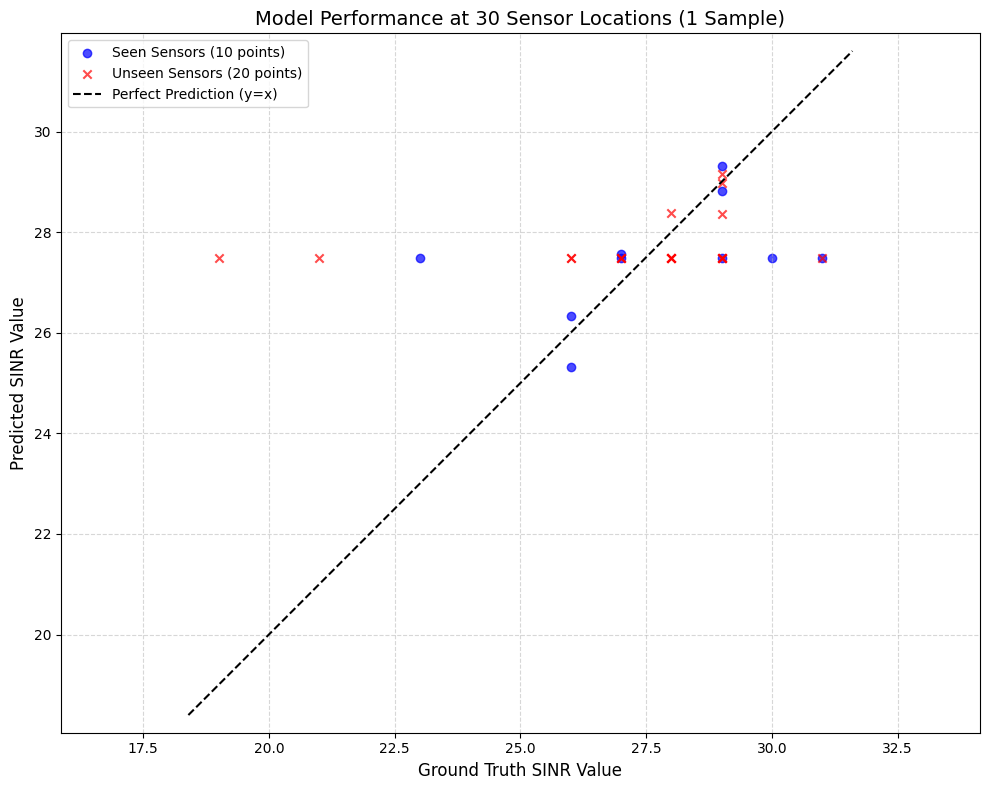

In [32]:
# ===============================================================
# 7️⃣ Scatter Plot for Direct Performance Comparison
# ===============================================================
print("\n--- Generating scatter plot for performance comparison ---")
try:
    # We already have these from Section 5:
    # seen_gt, seen_pred (for 11 seen sensors)
    # unseen_gt, unseen_pred (for 19 unseen sensors)
    
    # Detach from device and convert to numpy
    seen_gt_np = seen_gt.cpu().numpy()
    seen_pred_np = seen_pred.cpu().numpy()
    unseen_gt_np = unseen_gt.cpu().numpy()
    unseen_pred_np = unseen_pred.cpu().numpy()

    # Create a new figure
    plt.figure(figsize=(10, 8))
    
    # Plot Seen sensors
    plt.scatter(seen_gt_np, seen_pred_np, color='blue', alpha=0.7, label=f'Seen Sensors ({len(seen_gt_np)} points)')
    
    # Plot Unseen sensors
    plt.scatter(unseen_gt_np, unseen_pred_np, color='red', marker='x', alpha=0.7, label=f'Unseen Sensors ({len(unseen_gt_np)} points)')
    
    # Add a y=x line (perfect prediction line)
    all_gt = np.concatenate((seen_gt_np, unseen_gt_np))
    all_pred = np.concatenate((seen_pred_np, unseen_pred_np))
    min_val = min(all_gt.min(), all_pred.min())
    max_val = max(all_gt.max(), all_pred.max())
    padding = (max_val - min_val) * 0.05 # Add 5% padding
    
    plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding], 'k--', label='Perfect Prediction (y=x)')
    
    plt.xlabel("Ground Truth SINR Value", fontsize=12)
    plt.ylabel("Predicted SINR Value", fontsize=12)
    plt.title("Model Performance at 30 Sensor Locations (1 Sample)", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal') # Ensure x and y axes have the same scale
    plt.tight_layout()


except ImportError:
    print("\n[WARNING] Matplotlib not found. Skipping scatter plot generation.")
except Exception as e:
    print(f"\n[WARNING] Could not generate scatter plot. Error: {e}")


--- Generating 1x2 Plot: Ground Truth vs. Full Prediction ---
Plotting results...


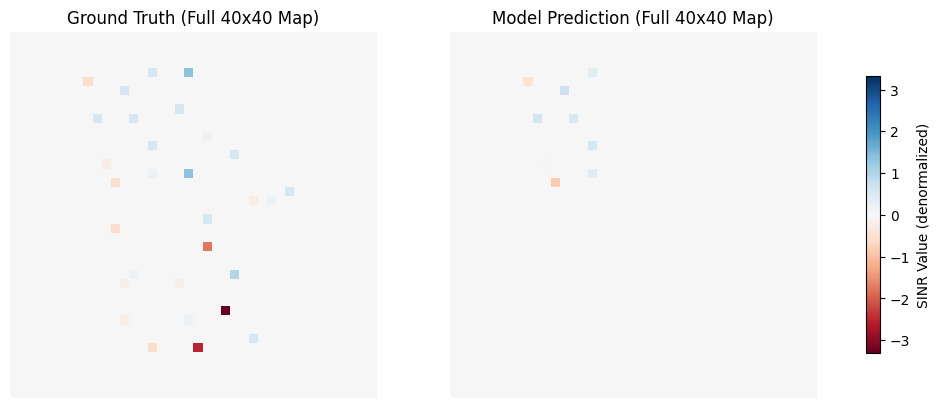

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assumes these variables are already loaded in your environment ---
# model, val_loader, device, loc_mask_base, H, W
# val_coords_y, val_coords_x
# global_normalization_std, global_normalization_mean
# --- ----------------------------------------------------------- ---

print("\n--- Generating 1x2 Plot: Ground Truth vs. Full Prediction ---")

model.eval()
with torch.no_grad():
    # 1. Get one full ground truth sample from the validation data
    try:
        (x_batch,) = next(iter(val_loader))
    except StopIteration:
        print("Resetting val_loader.")
        (x_batch,) = next(iter(val_loader))
        
    # Get the first sample and put it on the device
    # This is the full 40x40 Ground Truth map
    gt_sample = x_batch[0].to(device).unsqueeze(0) # Shape: (1, 1, H, W)

    # 2. Create the sparse input map that the model needs
    # The model can't predict from nothing; it reconstructs from these points.
    seen_mask_for_input = torch.zeros(1, 1, H, W, device=device)
    seen_mask_for_input[0, 0, val_coords_y, val_coords_x] = 1.0
    
    input_sample = gt_sample * seen_mask_for_input
    
    # 3. Get the full 40x40 prediction from the model
    loc_sample = loc_mask_base.unsqueeze(0).to(device) # Location grid
    
    # Run the model
    pred_sample, _, _, _ = model(input_sample, loc_sample, seen_mask_for_input)

    # 4. Denormalize both maps to get real SINR values
    #gt_denorm = gt_sample * global_normalization_std + global_normalization_mean
    #pred_denorm = pred_sample * global_normalization_std + global_normalization_mean

# --- 5. Visualization ---
print("Plotting results...")

# 1. Get maps as numpy arrays
gt_map = gt_sample.cpu().numpy().squeeze()
pred_map = pred_sample.cpu().numpy().squeeze()

# 2. Find a SYMMETRIC range
# This finds the largest absolute value (e.g., 30)
v_abs = max(np.abs(gt_map).max(), np.abs(pred_map).max())
# This forces the range to be, e.g., [-30, +30]
vmin = -v_abs 
vmax = v_abs

# 3. Plot WITH the fixed range
#    Also, use cmap='RdBu' (Red=high, Blue=low)
#    Your image shows Red=high, but your old code said 'RdBu_r' (reversed)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# --- ADD vmin AND vmax HERE ---
im1 = ax1.imshow(gt_map, cmap='RdBu', vmin=vmin, vmax=vmax) 
ax1.set_title(f"Ground Truth (Full {H}x{W} Map)")
ax1.set_axis_off()

# --- ADD vmin AND vmax HERE ---
im2 = ax2.imshow(pred_map, cmap='RdBu', vmin=vmin, vmax=vmax)
ax2.set_title(f"Model Prediction (Full {H}x{W} Map)")
ax2.set_axis_off()

fig.colorbar(im2, ax=[ax1, ax2], shrink=0.6, label="SINR Value (denormalized)")
plt.show()